# Local Invariant Features for Object Detection
## Computer Vision and Image Processing - Lab Session 6 - Exercises Solutions
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Pierluigi Zama Ramirez, pierluigi.zama@unibo.it

### Exercise 1: Object Detection
Given a query image ('ex/bishop.jpg') detect the object in the scene images: 'scene1.jpg', 'scene2.jpg' and 'scene3.jpg'.

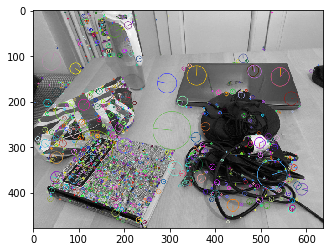

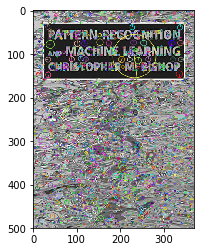

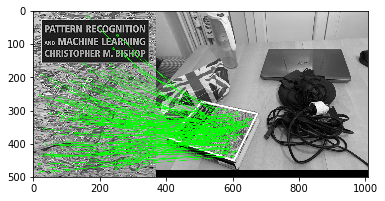

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load the query and the train images
img_train = cv2.imread('ex/scene1.jpg',0) # trainImage
img_query = cv2.imread('ex/bishop.jpg',0) # queryImage

# Creating SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Detecting Keypoints in the two images
kp_query = sift.detect(img_query)
kp_train = sift.detect(img_train)

# Visualizing the found Keypoints
img_visualization = cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization)
plt.show()

img_visualization = cv2.drawKeypoints(img_query,kp_query,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization)
plt.show()

# Computing the descriptors for each keypoint
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(des_query,des_train,k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
# If we have at least 10 matches we find the box of the object
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Matches mask for visualization of only matches used by RANSAC
    matchesMask = mask.ravel().tolist()

    # Apply homography to project corners of the query image into the image
    h,w = img_query.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    # Drawing bounding box
    img_train = cv2.polylines(img_train,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

# Drawing matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img_query,kp_query,img_train,kp_train,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

### Exercise 2: Image Search
Given a query image ('ex/bishop.jpg') and several train images ('ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg', 'ex/scene4.jpg', 'ex/scene5.jpg') implement an image search algorithm to find which images contain the query object.

Found query object in ex/scene1.jpg:True


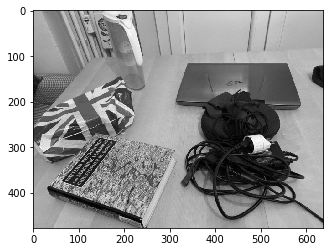

Found query object in ex/scene2.jpg:True


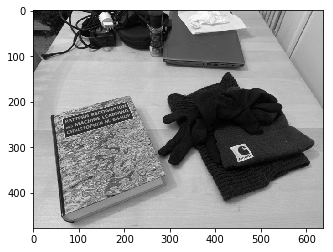

Found query object in ex/scene3.jpg:True


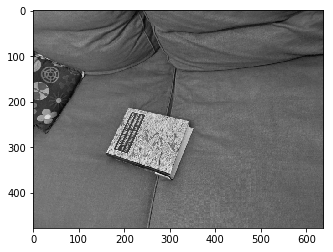

Found query object in ex/scene4.jpg:False
Found query object in ex/scene5.jpg:False


In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Define a function for object detection pipeline
def object_retrieve(img_query, img_train, min_match_count):
    sift = cv2.xfeatures2d.SIFT_create()
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train, kp_train)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query,des_train,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)>min_match_count:
        return len(good)
    else:
        return -1

img_query = cv2.imread('ex/bishop.jpg',0) # queryImage
imgs_train = ['ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg', 'ex/scene4.jpg', 'ex/scene5.jpg']

# Iterating among all images and looking for the query object.
for path in imgs_train:
    img_train = cv2.imread(path,0)
    found = object_retrieve(img_query, img_train, 50)
    print("Found query object in {}:{}".format(path,found > 0))
    if found > 0:
        plt.imshow(img_train, 'gray', vmin= 0, vmax=255)
        plt.show()

### Exercise 3: Mosaicing (aka Panorama Stitching)
Given two images stitch them in a single image. 

Test it on 'ex/panorama_left_rgb.jpg' and 'ex/panorama_right_rgb.jpg' or 'ex/panorama_left.jpg' and 'ex/panorama_right.jpg'.

_Tips:_ 
* Find correspondences between the two images
* Find an homography
* Warp one image and restore values for the other image 

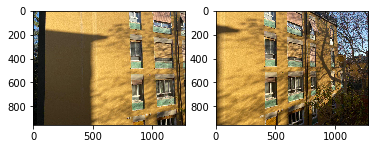

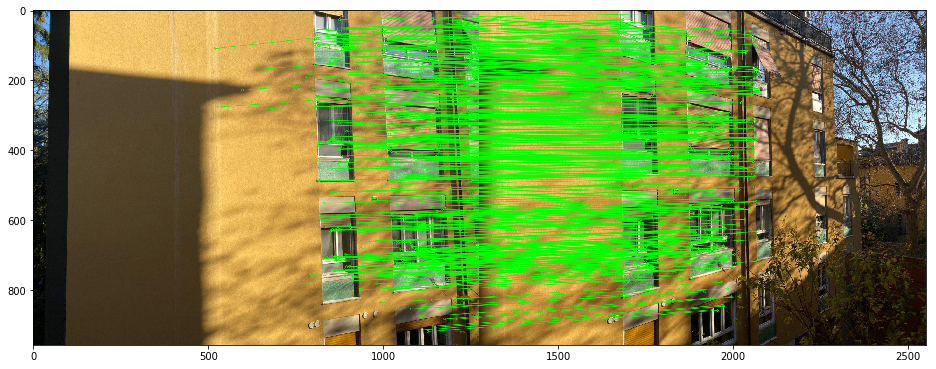

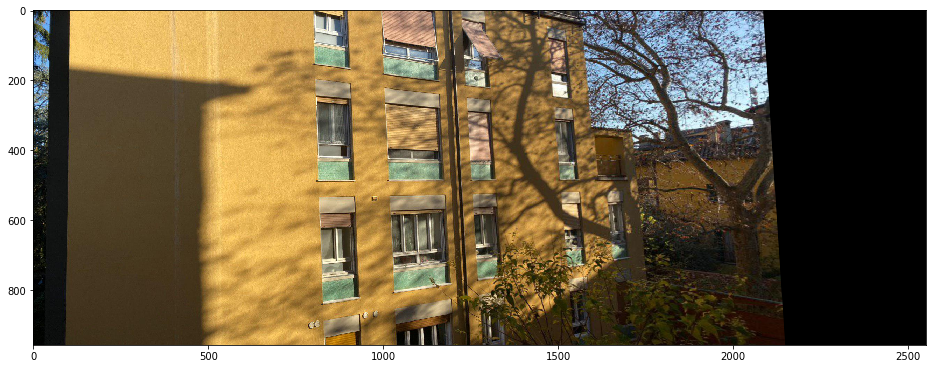

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Loading images
img1 = cv2.imread('ex/panorama_left_rgb.jpg')[:,:,::-1] 
img2 = cv2.imread('ex/panorama_right_rgb.jpg')[:,:,::-1]
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()

# Getting correspondences
sift = cv2.xfeatures2d.SIFT_create()
kp1 = sift.detect(img1)
kp2 = sift.detect(img2)
kp1, des1 = sift.compute(img1, kp1)
kp2, des2 = sift.compute(img2, kp2)
    
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# Finding an homography
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

# Drawing matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(16,8))
plt.imshow(img3)
plt.show()  

# Warping right image with the homography. Result images having a bigger shape to contain both images.
result = cv2.warpPerspective(img2, M, (img1.shape[1] + img2.shape[1], img2.shape[0]))

# Restoring left image values into the result image
result[0:img1.shape[0], 0:img1.shape[1]] = img1

# Displaying the result
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.show()

### Exercise 4: Augmentated Reality 
Given an image ('ex/stregatto.jpg') implement an augmented reality algorithm to project the image into the surface of the query object ('ex/bishop.jpg).

Moreover, restore the values of the original scene image instead of black pixels obtained with warping. 

Test it on scene images 'ex/scene1.jpg', 'ex/scene2.jpg', 'ex/scene3.jpg'.

_Expected Results_:

<img src="LabSession6Images/ar_ex.png" width="400">

Scene Image


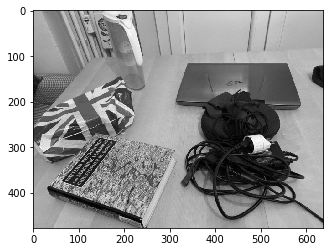

Query Image


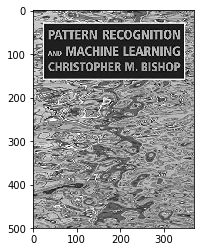

Image to Project


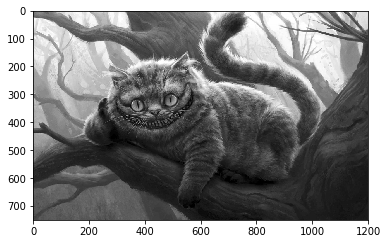

Result Image


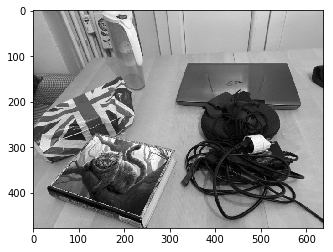

In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Loading images
img_train = cv2.imread('ex/scene1.jpg',0) # trainImage
img_query = cv2.imread('ex/bishop.jpg',0) # queryImage
img_ar = cv2.imread('ex/stregatto.jpg',0) # queryImage

print("Scene Image")
plt.imshow(img_train, 'gray', vmin=0, vmax=255)
plt.show()
print("Query Image")
plt.imshow(img_query, 'gray', vmin=0, vmax=255)
plt.show()
print("Image to Project")
plt.imshow(img_ar, 'gray', vmin=0, vmax=255)
plt.show()

# For a better visualization in this scene image. Try to find the best rotation dynamically according to the query object.
img_ar = np.rot90(img_ar, 3) #rotate 270

# Implementing the object detection pipeline
sift = cv2.xfeatures2d.SIFT_create()
kp_query = sift.detect(img_query)
kp_train = sift.detect(img_train)
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_query,des_train,k=2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# Checking if we found the object
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Getting the coordinates of the corners of our query object in the train image
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img_query.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    h_t, w_t = img_train.shape
    h,w = img_ar.shape
    
    # Getting the homography to project img_ar on the surface of the query object.
    pts_stregatto = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    M = cv2.getPerspectiveTransform(pts_stregatto,dst)

    # Warping the img_ar
    warped = cv2.warpPerspective(img_ar, M, (w_t, h_t))

    # Warp a white mask to understand what are the black pixels
    white = np.ones([h,w],dtype=np.uint8)*255
    warp_mask = cv2.warpPerspective(white, M, (w_t, h_t))
    
    # Restore previous values of the train images where the mask is black
    warp_mask = np.equal(warp_mask, 0)
    warped[warp_mask] = img_train[warp_mask]
    
    # Displaying the result
    print("Result Image")
    plt.imshow(warped,'gray',vmin=0,vmax=255)
    plt.show()
    cv2.imwrite("ar.png",warped)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None